# Welcome!

This notebook uses the setup from [my github directory](https://github.com/max-wild/Mask-Object-Detection) to train an imported neural network with to recognize:  

*   Face masks
*   No face masks
*   Improperly used face masks

on faces in pictures. 

This is done with the **Python Tensorflow package**, hosted on **Google Colab**.

<br>
<hr> 
<br>

<img src="https://github.com/max-wild/Mask-Object-Detection/raw/main/products/detect2.png" alt="drawing" width="300" ALIGN="left"/>

After training, this notebook exports the model, where it can be tested using new test images (either the ones provided from my github or uploaded from your own machine).

# Downloading and Installing Tools

In [ ]:
# Clone the tensorflow models on the colab cloud vm
!git clone --q https://github.com/tensorflow/models.git

!pip install tf-models-official==2.8.0  # Very important so that everything works together

# Navigate to /models/research folder to compile protos
%cd models/research

# Compile protos.
!protoc object_detection/protos/*.proto --python_out=.

# Install TensorFlow Object Detection API.
!cp object_detection/packages/tf2/setup.py .
!python -m pip install .

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.2 MB 19.5 MB/s 
     |████████████████████████████████| 1.3 MB 66.1 MB/s 
     |████████████████████████████████| 99 kB 10.0 MB/s 
     |████████████████████████████████| 352 kB 64.7 MB/s 
     |████████████████████████████████| 636 kB 63.3 MB/s 
     |████████████████████████████████| 1.1 MB 57.3 MB/s 
     |████████████████████████████████| 238 kB 76.9 MB/s 
     |████████████████████████████████| 4.9 MB 63.7 MB/s 
     |████████████████████████████████| 116 kB 51.9 MB/s 
     |████████████████████████████████| 518.1 MB 23 kB/s 
     |████████████████████████████████| 43 kB 2.6 MB/s 
     |████████████████████████████████| 462 kB 69.9 MB/s 
     |████████████████████████████████| 1.4 MB 61.8 MB/s 
     |████████████████████████████████| 5.8 MB 62.6 MB/s 
  Created wheel for py-cpuinfo: filename=py_cpuinfo-8.0.0-py3-none-any.whl size=22257 sha256

In [ ]:
# Testing the model builder
!python object_detection/builders/model_builder_tf2_test.py

In [ ]:
# Download github directory and unzip it

%cd /content
!wget https://github.com/max-wild/Mask-Object-Detection/archive/refs/heads/main.zip

# Unzip and rename
!unzip main.zip
!mv Mask-Object-Detection-main/ mask_obj_detection/

!rm main.zip

/content
--2022-08-17 23:45:57--  https://github.com/max-wild/Mask-Object-Detection/archive/refs/heads/main.zip
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/max-wild/Mask-Object-Detection/zip/refs/heads/main [following]
--2022-08-17 23:45:58--  https://codeload.github.com/max-wild/Mask-Object-Detection/zip/refs/heads/main
Resolving codeload.github.com (codeload.github.com)... 140.82.112.10
Connecting to codeload.github.com (codeload.github.com)|140.82.112.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘main.zip’

main.zip                [           <=>      ] 397.61M  24.6MB/s    in 16s     

2022-08-17 23:46:14 (24.3 MB/s) - ‘main.zip’ saved [416920283]

Archive:  main.zip
98f30174279f2c9602fadb7acb161226b4eb2743
   creating: Mask-Object-Detection-main/
 

In [ ]:
%cd /content
!pwd

# Generating the .record files
*   They're too big to store in github



In [ ]:
import os
import glob
import pandas as pd
import io
import xml.etree.ElementTree as ET
import argparse

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'    # Suppress TensorFlow logging (1)
import tensorflow.compat.v1 as tf
from PIL import Image
from object_detection.utils import dataset_util
from collections import namedtuple


output_path = '/content/mask_obj_detection/annotations/{}.record'
xml_dir = '/content/mask_obj_detection/images/{}'


def xml_to_csv(path):
    """Iterates through all .xml files (generated by labelImg) in a given directory and combines
    them in a single Pandas dataframe.

    Parameters:
    ----------
    path : str
        The path containing the .xml files
    Returns
    -------
    Pandas DataFrame
        The produced dataframe
    """

    xml_list = []
    for xml_file in glob.glob(path + '/*.xml'):
        tree = ET.parse(xml_file)
        root = tree.getroot()
        filename = root.find('filename').text
        width = int(root.find('size').find('width').text)
        height = int(root.find('size').find('height').text)
        for member in root.findall('object'):
            bndbox = member.find('bndbox')
            value = (filename,
                    width,
                    height,
                    member.find('name').text,
                    int(bndbox.find('xmin').text),
                    int(bndbox.find('ymin').text),
                    int(bndbox.find('xmax').text),
                    int(bndbox.find('ymax').text),
                    )
            xml_list.append(value)
    column_name = ['filename', 'width', 'height',
                  'class', 'xmin', 'ymin', 'xmax', 'ymax']
    xml_df = pd.DataFrame(xml_list, columns=column_name)
    return xml_df


def class_text_to_int(row_label):

    if row_label == 'with_mask':
        return 1
    if row_label == 'without_mask':
        return 2
    if row_label == 'mask_weared_incorrect':
        return 3
    else:
        None


def split(df, group):
    data = namedtuple('data', ['filename', 'object'])
    gb = df.groupby(group)
    return [data(filename, gb.get_group(x)) for filename, x in zip(gb.groups.keys(), gb.groups)]


def create_tf_example(group, path):
    with tf.io.gfile.GFile(os.path.join(path, '{}'.format(group.filename)), 'rb') as fid:
        encoded_jpg = fid.read()
    encoded_jpg_io = io.BytesIO(encoded_jpg)
    image = Image.open(encoded_jpg_io)
    width, height = image.size

    filename = group.filename.encode('utf8')
    image_format = b'jpg'
    xmins = []
    xmaxs = []
    ymins = []
    ymaxs = []
    classes_text = []
    classes = []

    for index, row in group.object.iterrows():
        xmins.append(row['xmin'] / width)
        xmaxs.append(row['xmax'] / width)
        ymins.append(row['ymin'] / height)
        ymaxs.append(row['ymax'] / height)
        classes_text.append(row['class'].encode('utf8'))
        classes.append(class_text_to_int(row['class']))

    tf_example = tf.train.Example(features=tf.train.Features(feature={
        'image/height': dataset_util.int64_feature(height),
        'image/width': dataset_util.int64_feature(width),
        'image/filename': dataset_util.bytes_feature(filename),
        'image/source_id': dataset_util.bytes_feature(filename),
        'image/encoded': dataset_util.bytes_feature(encoded_jpg),
        'image/format': dataset_util.bytes_feature(image_format),
        'image/object/bbox/xmin': dataset_util.float_list_feature(xmins),
        'image/object/bbox/xmax': dataset_util.float_list_feature(xmaxs),
        'image/object/bbox/ymin': dataset_util.float_list_feature(ymins),
        'image/object/bbox/ymax': dataset_util.float_list_feature(ymaxs),
        'image/object/class/text': dataset_util.bytes_list_feature(classes_text),
        'image/object/class/label': dataset_util.int64_list_feature(classes),
    }))
    return tf_example


def create_tf_record(path_type):

    writer = tf.python_io.TFRecordWriter(output_path.format(path_type))
    path = os.path.join(xml_dir.format(path_type))
    examples = xml_to_csv(xml_dir.format(path_type))
    grouped = split(examples, 'filename')
    for group in grouped:
        tf_example = create_tf_example(group, path)
        writer.write(tf_example.SerializeToString())
    writer.close()
    print('Successfully created the TFRecord file: {}'.format(output_path.format(path_type)))


def main():
    create_tf_record('train')
    create_tf_record('test')


if __name__ == '__main__':
    main()

Successfully created the TFRecord file: /content/mask_obj_detection/annotations/train.record
Successfully created the TFRecord file: /content/mask_obj_detection/annotations/test.record


# Downloading the Pre-trained Model from the Tensorflow Zoo:

*    This project is using the SSD ResNet50 V1 FPN 640x640



In [ ]:
%cd /content/mask_obj_detection/pre-trained-models/

!wget http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
!tar -xf ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz

# The current model's pipeline.config has already been set up from github
%cd /content/

# Downloading Tensorboard
TensorBoard lets you oversee and visualize training metrics during training

In [ ]:
%load_ext tensorboard
%tensorboard --logdir '/content/mask_obj_detection/models/my_ssd_resnet50_v1_fpn'

# Training the Model

In [ ]:
# Setting paths to Model directory & Pipeline config file:a
os.environ['MODEL_DIR']='/content/mask_obj_detection/models/my_ssd_resnet50_v1_fpn'
os.environ['PIPELINE_CONFIG_PATH']='/content/mask_obj_detection/models/my_ssd_resnet50_v1_fpn/pipeline.config'
# os.environ['NUM_TRAIN_STEPS']='50000'

# Validating environment variables.
!echo MODEL_DIR = ${MODEL_DIR}
!echo PIPELINE_CONFIG_PATH = ${PIPELINE_CONFIG_PATH}

MODEL_DIR = /content/mask_obj_detection/models/my_ssd_resnet50_v1_fpn
PIPELINE_CONFIG_PATH = /content/mask_obj_detection/models/my_ssd_resnet50_v1_fpn/pipeline.config


Shell command which actually trains the model: 

In [ ]:
!python mask_obj_detection/model_main_tf2.py --model_dir=${MODEL_DIR} --pipeline_config_path=${PIPELINE_CONFIG_PATH} --alsologtostderr

^C


# Export the New Model

In [ ]:
%cd /content/mask_obj_detection

!python models/exporter_main_v2.py --input_type image_tensor --pipeline_config_path models/my_ssd_resnet50_v1_fpn/pipeline.config --trained_checkpoint_dir models/my_ssd_resnet50_v1_fpn/ --output_directory exported-models/my_model

/content/mask_obj_detection
2022-08-17 15:47:01.778847: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.map_fn(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.map_fn(fn, elems))
W0817 15:47:01.949049 139950184310656 deprecation.py:615] From /usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:458: calling map_fn_v2 (from tensorflow.python.ops.map_fn) with back_prop=False is deprecated and will be removed in a future version.
Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.map_fn(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.map_fn(fn, elems))
2022-

# Testing the New Model

In [ ]:
PATH_SAVED_MODEL = '/content/mask_obj_detection/exported-models/my_model/saved_model'
PATH_LABEL_MAP = '/content/mask_obj_detection/annotations/label_map.pbtxt'
PATH_TEST_IMAGE = '/content/mask_obj_detection/images/test/maksssksksss785.png'

Loading model...Done!


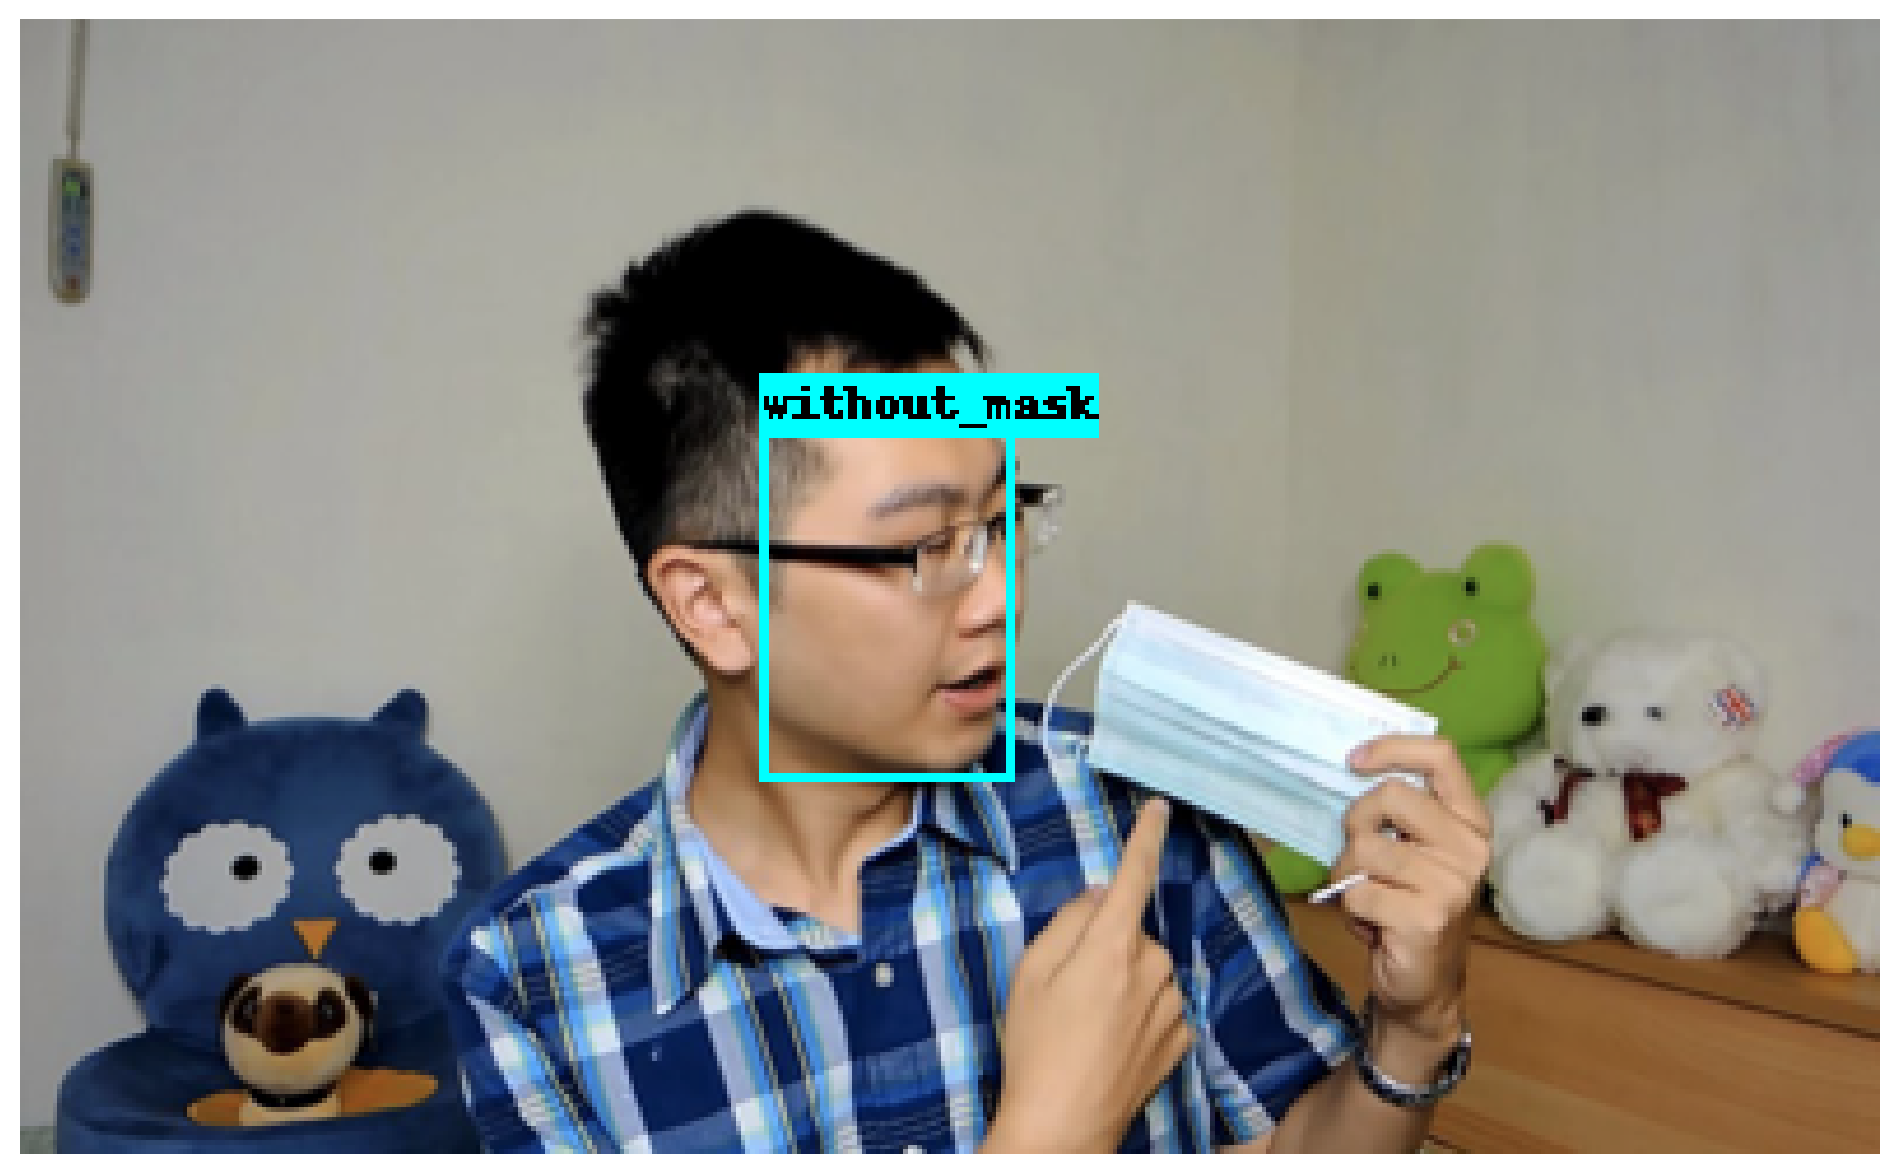

In [ ]:
#Loading the saved_model
import tensorflow as tf
import time
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from PIL import Image
from google.colab.patches import cv2_imshow
import cv2
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils

IMAGE_SIZE = (12, 8) # Output display size as you want
import matplotlib.pyplot as plt
print('Loading model...', end='')

# Load saved model and build the detection function
detect_fn=tf.saved_model.load(PATH_SAVED_MODEL)
print('Done!')

#Loading the label_map
category_index=label_map_util.create_category_index_from_labelmap(PATH_LABEL_MAP,use_display_name=True)
#category_index=label_map_util.create_category_index_from_labelmap([path_to_label_map],use_display_name=True)

def load_image_into_numpy_array(path):

    img1 = np.array(cv2.imread(path))

    # Switching BGR to RGB
    b,g,r = cv2.split(img1)           # get b, g, r
    return cv2.merge([r,g,b])         # switch it to r, g, b
    # return np.array(Image.open(path))

# print('Running inference for {}... '.format(PATH_TEST_IMAGE), end='')

image_np = load_image_into_numpy_array(PATH_TEST_IMAGE)

# The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
input_tensor = tf.convert_to_tensor(image_np)
# The model expects a batch of images, so add an axis with `tf.newaxis`.
input_tensor = input_tensor[tf.newaxis, ...]

detections = detect_fn(input_tensor)

# All outputs are batches tensors.
# Convert to numpy arrays, and take index [0] to remove the batch dimension.
# We're only interested in the first num_detections.
num_detections = int(detections.pop('num_detections'))
detections = {key: value[0, :num_detections].numpy()
              for key, value in detections.items()}
detections['num_detections'] = num_detections

# detection_classes should be ints.
detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

image_np_with_detections = image_np.copy()

viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_detections,
      detections['detection_boxes'],
      detections['detection_classes'],
      detections['detection_scores'],
      category_index,
      use_normalized_coordinates=True,
      max_boxes_to_draw=200,
      line_thickness=2,
      skip_scores=True,
      min_score_thresh=.4, # Adjust this value to set the minimum probability boxes to be classified as True
      agnostic_mode=False)
%matplotlib inline
plt.figure(figsize=IMAGE_SIZE, dpi=200)
plt.axis("off")
plt.imshow(image_np_with_detections)
plt.show()